# Excited States from TDDFT
**by <span style="color:darkgreen">Stephan Sagmeister</span>, <span style="color:darkgreen">Santiago Rigamonti</span>  & <span style="color:darkgreen">Ronaldo Rodrigues Pela</span> for [<span style="color:DarkGoldenRod">exciting *oxygen*</span>](http://exciting.wikidot.com/oxygen)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Megha Arya</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to perform a basic time-dependent density-functional theory (**TDDFT**) calculation. As an example, the loss function of bulk silver is studied for the optical case (long-wavelength limit **q**=0).

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Preparation](#0)
    
[1. Theoretical Background for TDDFT Calculation](#1)
        
[2. Ground-State Calculation](#2)
    
  - Preparation of the Input File
  - Running the Ground-State Calculation
    
[3. How to Perform a TDDFT Calculation](#3)
    
  - Setting Elements and Attributes
  - General Comments on Input Parameters for TDDFT
  - Running exciting
  - Output Files
    
[4. Visualizing the Output](#4)
    
[5. Converging the Results](#5)
    
  - Exercise

[6. Try a Different Kernel](#6)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Preparation</span>

**<span style="color:firebrick">Read the following paragraph before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **exciting**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** All input parameters that will appear will be given in **atomic units**!

Determine the root directory of **exciting**, in which the binary executables as well as the species files are located by executing the following cell.

In [1]:
import os
from os import getcwd
from os.path import join
from excitingjupyter.utilities import get_exciting_root

exciting_root = get_exciting_root()
exciting_species = join(exciting_root, "species")
print(exciting_root)

/users/tfk/amegha/exciting


<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background for TDDFT Calculation</span>

In this application of **TDDFT**, we want to calculate the loss function for the optical case (*i.e.*, for **q**=0). The loss function is the quantity which is directly measurable using electron-energy loss spectroscopy (**EELS**). The loss function L(**q**,*ω*) is defined as

\begin{equation}
\tag{1}
L(\mathbf q, \mathit ω) = -Im \Big[\varepsilon_{M}(\mathbf q,\mathit ω)\Big]^{-1}, 
\end{equation}

where $\varepsilon_{M}(\mathbf q,\mathit ω)$ is the macroscopic dielectric function which, in turn, is related to the inverse dielectric matrix by

\begin{equation}
\tag{2}
\Big[\varepsilon_{M}(\mathbf q,\mathit ω)\Big]^{-1} = \varepsilon_{00}^{-1}(\mathbf q,\mathit ω).
\end{equation}

The inverse dielectric matrix is given by $\varepsilon^{-1} = 1 + \nu \chi$, where $\nu$ is the bare Coulomb kernel and $\chi$ is the reducible polarizability. The latter is obtained in **exciting** using the linear response to **TDDFT** through the solution of the Dyson equation

\begin{equation}
\tag{3}
\chi = \chi_{0} + \chi_{0} (\nu + f_{xc}) \chi ,
\end{equation}

where $\chi_{0}$ is the Kohn-Sham independent-particle polarizability and $f_{xc}$ is the exchange-correlation kernel. The neglect of the $f_{xc}$ term corresponds to the random-phase approximation (**RPA**). In actual calculations, the different response functions are represented by their Fourier expansion. The size of the matrices of Fourier components which represent the response functions is limited through the cutoff value **<span style="color:green">G<sub>max</sub></span>** in such a way that only matrix elements ***X*<sub>G,G'</sub>**(**q**) with both |**q**+**G**|, |**q**+**G'**| < G<sub>max</sub> are taken into account (***X*** = $\chi_{0}, \chi$, *etc*.). If **<span style="color:firebrick">G<sub>max</sub> > 0</span>** the calculation is said to include (fully or partially, depending on the size of G<sub>max</sub>) **<span style="color:firebrick">local field effects</span>** (**LFE**).

<hr style="border:1px solid #DDD"> </hr>

<details>
<summary><strong><span style="color:firebrick">$\Rightarrow$ Work-Flow of a TDDFT Linear-Response Calculation</span></strong>
 
<hr style="border:1px solid #DDD"> </hr>    
    
</summary>    
    
The calculation of the different quantities involved determines the work-flow of a **TDDFT** linear-response calculation, as discussed in the following.

1. Eigenvalues $\varepsilon_{n \mathbf k}$ and wavefunctions $\psi_{n \mathbf k} (\mathbf r)$ of the Kohn-Sham equations are determined for a given **k**-mesh.
2. Momentum matrix elements, $\rho_{α,nm \mathbf k} = < \psi_{n \mathbf k} | \rho_{α} | \psi_{m \mathbf k} >$, are calculated.
3. **q**-dependent matrix elements of plane waves, $M_{nm \mathbf k}(\mathbf q,\mathbf G) = < \psi_{n \mathbf k} | exp[-i(\mathbf q + \mathbf G) \mathbf r] | \psi_{m \mathbf k+q} >$, are evaluated.
4. The Kohn-Sham response function $\chi_{0}$ is assembled including the matrix elements
    - only $\rho_{α,nm \mathbf k}$ for **q**=0 without **LFE**,
    - both $\rho_{α,nm \mathbf k}$ and $M_{nm \mathbf k}$(0,**G**) for **q**=0 with **LFE**,
    - only $M_{nm \mathbf k}$(**q**,**G**) for finite momentum transfer (**q** different from 0).  


5. In a last step the Dyson equation for the interacting response function $\chi$ is solved and the macroscopic dielectric function $\varepsilon_{M}$ is obtained therefrom. For **q**=0, all diagonal tensor components of the macroscopic dielectric function are calculated by default.  


In the following flow chart, each level along a horizontal axis denotes quantities which are independent from each other.


<div>
<img src="images_excited_states_from_tddft/TDDFTsimple.png" width="500" align="left"/>
</div>

</details>  

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Ground-State Calculation</span>

**i) Preparation of the Input File**

The first step is to create a directory for the system that we want to investigate. In this tutorial, we consider as an example the calculation of the loss function for silver in the fcc cubic structure. Thus, we will create a directory **Ag-tddft** and we move inside it.

As for all other tutorials, you can choose between executing all steps manually from your command line, or to simply execute the python cells in this Jupyter notebook.

In [2]:
%%bash
# Create working directory 
mkdir -p Ag-tddft

In [3]:
cwd = join(getcwd(), 'Ag-tddft')

As a starting point for the **TDDFT** calculation, we need converged electron density and potential. To this end, we perform a ground-state calculation. Therefore, we create (or copy from a previous calculation) the file **input.xml** that could look like the following.

```xml
<input>
 
   <title>Loss function of Ag: Ground-State Calculation</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="7.72">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>
      <species speciesfile="Ag.xml">
         <atom coord="0.0  0.0  0.0" />
      </species>
   </structure>
 
   <groundstate
      xctype="GGA_PBE_SOL"
      ngridk="10 10 10" />
 
</input>

```

For manual execution, copy and paste the above into the new file **input.xml**. For an execution within the notebook, execute the following cells.

In [ ]:
# Writing the input as an XML file
from excitingjupyter.utilities import re_input

notebook = join(os.getcwd(), 'excited_states_from_tddft.ipynb')
input_str = re_input(notebook, "Loss function of Ag: Ground-State Calculation")
with open(join(cwd, 'input.xml'), "w") as fid:
    fid.write(input_str)

In [ ]:
# Replacing the string "$EXCITINGROOT/species" in input.xml by the actual value of the environment variable
with open(join(cwd, 'input.xml'), "r+") as fin:
    file_content = fin.read()
    file_content = file_content.replace('$EXCITINGROOT/species', f'{exciting_species}')
    fin.seek(0)
    fin.write(file_content)

Please, remember that the input file for an **exciting** calculation must be always called **input.xml**. For further details see [<span style="color:firebrick">Input Reference</span>](http://exciting.wikidot.com/ref:input) and [<span style="color:firebrick">How to start an exciting calculation</span>](http://exciting.wikidot.com/oxygen-how-to-start-an-exciting-calculation).

**ii) Running the Ground-State Calculation**

In order to run **exciting**, you simply need to execute the **exciting_smp** binary in the running directory. After a few seconds, the calculation should be finished.

Here we use the <code>time</code> command before **exciting_smp** in order to get, at the end of the run, the elapsed time explicitly written on the screen.

In [ ]:
%%bash
# Move into the run directory
cd Ag-tddft
# Load the necessary modules
module load intel
# Run exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
# Move back to parent directory 
cd ..

You can check the bunch of files created during the run, especially the main output file **INFO.OUT**, for convergence information. If the calculation of the ground state has been finished successfully, in the last lines of the **INFO.OUT** file you should find the message

<div style="background-color: rgb(224, 224, 224);">
    
```bash
...
================================================================================
| EXCITING OXYGEN stopped                                                      =
================================================================================
```
</div>

This can be checked within the notebook by executing the following cell.

In [ ]:
!tail -n 3 Ag-tddft/INFO.OUT

Check if the calculation finishes gracefully and if the **EFERMI.OUT** and **STATE.OUT** files are present. These files contain the **<span style="color:green">Fermi level</span>** and the converged **<span style="color:green">electron density and potential</span>**, respectively, and are the starting point of the **TDDFT** calculation.

**<span style="color:firebrick">Please note</span>**: To obtain reliable results it is necessary to perform careful convergence tests with respect to the k-point mesh (parameter <code><span style="color:mediumblue">ngridk</span></code>) and the size of the basis set (parameter <code><span style="color:mediumblue">rgkmax</span></code>). For details see [<span style="color:firebrick">Simple convergence tests</span>](http://exciting.wikidot.com/oxygen-simple-convergence-tests).

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. How to Perform a TDDFT Calculation</span>

**Setting Elements and Attributes**

If you have already performed the (ground-state) calculation shown in **<span style="color:firebrick">Section 2</span>**, you can prepare the input file (**input.xml**) of a **TDDFT** calculation starting from the existing ground-state input file (&#65339;[<span style="color:firebrick">1</span>](#7)&#65341;) according to the following: First, the explicit ground-state calculation can now be skipped by adding the <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> attribute to the element <code><span style="color:green">groundstate</span></code>.

In order to perform a calculation of the **<span style="color:firebrick">excited states</span>**, a new block, corresponding to the element <code><span style="color:green">xs</span></code>, must be added to the input file inside the <code><span style="color:green">input</span></code> element. Now the file **input.xml** will look like the following.

```xml
<input>
 
   <title>Loss function of Ag: TDDFT Calculation using RPA</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="7.72">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>
      <species speciesfile="Ag.xml">
         <atom coord="0.0  0.0  0.0" />
      </species>
   </structure>
 
   <groundstate
      do="skip"   
      xctype="GGA_PBE_SOL"
      ngridk="10 10 10" />
      
    <xs 
      xstype ="TDDFT"
      ngridk="8 8 8" 
      vkloff="0.097 0.273 0.493"
      nempty="30"
      gqmax="2.0"
      broad="0.004"
      tevout="true">
 
      <energywindow 
         intv="0.0 2.0" 
         points="500" />
 
      <tddft 
         fxctype="RPA"/>
 
      <qpointset>
          <qpoint> 0.0 0.0 0.0 </qpoint>
      </qpointset>
 
   </xs>
 
</input>

```

For manual execution, update the **input.xml** file on terminal. For running the calculation in the notebook, execute the following cells.

In [ ]:
# Writing the input as an XML file
from excitingjupyter.utilities import re_input

notebook = join(os.getcwd(), 'excited_states_from_tddft.ipynb')
input_str = re_input(notebook, "Loss function of Ag: TDDFT Calculation using RPA")
with open(join(cwd, 'input.xml'), "w") as fid:
    fid.write(input_str)

In [ ]:
# Replacing the string "$EXCITINGROOT/species" in input.xml by the actual value of the environment variable
with open(join(cwd, 'input.xml'), "r+") as fin:
    file_content = fin.read()
    file_content = file_content.replace('$EXCITINGROOT/species', f'{exciting_species}')
    fin.seek(0)
    fin.write(file_content)

These settings in the input file correspond to a calculation with the following main features:

* It is a **TDDFT** calculation (the attribute <code><span style="color:mediumblue">xstype</span></code> is set to "**TDDFT**").
* It is using the random-phase approximation (**RPA**) for the exchange-correlation kernel (the attribute <code><span style="color:mediumblue">fxctype</span></code> of the subelement <code><span style="color:green">tddft</span></code> is set to "**RPA**").
* Local-field effects are included (the value of the cutoff **<span style="color:firebrick">G<sub>max</sub></span>**, defined by the attribute  <code><span style="color:mediumblue">gqmax</span></code> of the element <code><span style="color:green">xs</span></code>, is larger than zero). In order to neglect **LFE** in the calculation, <code><span style="color:mediumblue">gqmax</span></code> should be set to zero. Notice that, for the sake of comparison, results without the inclusion of **LFE** are always stored and can be found in the output files flagged with the **\_NLF\_** label (see [<span style="color:firebrick">TDDFT output files</span>](http://exciting.wikidot.com/tddft-output-files)).  

Now, make yourself familiar with the input parameters appearing in above (for details, see [<span style="color:firebrick">Input Reference</span>](http://exciting.wikidot.com/ref:xs)) and check if and how the chosen values differ from the default values.

**General Comments on Input Parameters for TDDFT**

* The k-point mesh (specified by the <code><span style="color:mediumblue">ngridk</span></code> attribute) is crucial for a good resolution of the spectra, though choosing a dense mesh can result into a time-consuming calculation. Therefore, the spectra always have to be converged with respect to the choice of this mesh.
* In general, it is a good practice to shift the k-mesh **<span style="color:green">off symmetry</span>** by modifying the  <code><span style="color:mediumblue">vkloff</span></code> attribute. Following this procedure, all points of the k mesh will be shifted by a small displacement. Such a displacement should break all symmetry relations among the k-points of the mesh. In this way, all the k-points in the mesh will be crystallographically inequivalent and there will be no redundant contribution to the spectrum.
* The q-vector (specified by the subelement <code><span style="color:green">qpoint</span></code> of <code><span style="color:green">qpointset</span></code>) defines whether an optical spectrum is calculated (q=0), or a finite momentum transfer is considered (q different from zero). Note that the q-vector is given in **<span style="color:green">crystal coordinates</span>**.
* The value of the attribute  <code><span style="color:mediumblue">broad</span></code> is a Lorentzian broadening for all spectra.
* The attribute  <code><span style="color:mediumblue">tevout</span></code> sets the energy output to be given in electronvolt (eV).
* The element <code><span style="color:green">energywindow</span></code> and its attributes allow to set the number and range of the energy values for which the spectra are calculated.

**Running exciting**

Having modified the input file according to the above prescription, you should now be able to launch the **TDDFT** calculation.

Again, running **exciting** can be done by executing the **exciting_smp** binary in the running directory.

In [ ]:
%%bash
# Move into the run directory
cd Ag-tddft
# Load the necessary modules
module load intel
# Run exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
# Move back to parent directory 
cd ..

You can check the progress of the **TDDFT** run by inspection of the file **INFOXS.OUT**. You will see detailed information about the several tasks executed. After every task (identified with a specific task number that is used for internal purposes of the code) is finished, the following message appears in the file

<div style="background-color: rgb(224, 224, 224);">
    
```bash
================================================================================
= EXCITING OXYGEN stopped for task    XXX                                      =
================================================================================
```
</div>

This does not mean that the complete **TDDFT** calculation has finished, but only the specific task **<span style="color:firebrick">XXX</span>**. The last task of a **TDDFT** calculation consists on the solution of the Dyson equation to obtain the dielectric function, the calculation of different spectra and the printing of them to corresponding files. It is labeled by the number **<span style="color:firebrick">350</span>**.

**Output Files**

While the calculation is running you can check the file **INFOXS.OUT**. Once the calculation is finished, a bunch of output files (see [<span style="color:firebrick">TDDFT output files</span>](http://exciting.wikidot.com/tddft-output-files)) will be present. Most of them containing a **\_QMTxxx** label. This stands for **q momentum transfer** and corresponds to the label **xxx** of the **q**-points listed in the **QPOINTS.OUT** file. For our q=0 case we will only have files containing a **\_QMT001** label.

Now, we will concentrate on the **LOSS\_** files and pick the output file **LOSS_FXCRPA_OC11_QMT001.OUT**. This file contains the data for the loss function and the dynamical structure factor. Details about the output files are described in [<span style="color:firebrick">TDDFT output files</span>](http://exciting.wikidot.com/tddft-output-files).

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Visualizing the Output</span>

From our command line, we can generate a PostScript (**PLOT.ps**) and a PNG (**PLOT.png**) output from the data file for the loss function by typing the following

<div style="background-color: rgb(224, 224, 224);">

```bash
$ PLOT-loss-function.py LOSS_FXCRPA_OC11_QMT001.OUT
```
    
</div>    

The plot can also be produced within this notebook by executing the following cell.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

loss_fxcRPA = np.genfromtxt(join(cwd, 'LOSS_FXCRPA_OC11_QMT001.OUT'))
plt.figure(figsize = (7, 5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot(loss_fxcRPA[:, 0], loss_fxcRPA[:, 1], color = "black")
plt.xlabel('Energy [eV]', fontsize = 16)
plt.ylabel('Loss function', fontsize = 16)
plt.xlim(0, 54)
plt.ylim(0.0, 1.4)
plt.show()

As you can see, on terminal, we are executing the **PLOT-loss-function.py** script with one argument, which is the name of one output file. You can add as many arguments (file names) in the command line as you like, and the script will add the corresponding curves to the same plot. If you wish to plot more than a file, do not forget to add in the command line the option <span style="color:blue">—kernel</span>. For example, to make a comparison between the loss function with and without local-field effects included, we can run the following command to generate a plot containing both loss functions.

<div style="background-color: rgb(224, 224, 224);">

```bash
$ PLOT-loss-function.py --kernel LOSS_FXCRPA_OC11_QMT001.OUT LOSS_NLF_FXCRPA_OC11_QMT001.OUT
```
</div>    

You should obtain a result similar to what is shown below:

<div>
<img src="images_excited_states_from_tddft/graph1.jpg" width="500" align="left"/>
</div>

In [ ]:
from matplotlib.lines import Line2D

loss_fxcRPA_nlf = np.genfromtxt(join(cwd, 'LOSS_NLF_FXCRPA_OC11_QMT001.OUT'))
plt.figure(figsize = (7, 5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot(loss_fxcRPA[:, 0], loss_fxcRPA[:, 1], color = "black")
plt.plot(loss_fxcRPA_nlf[:, 0], loss_fxcRPA_nlf[:, 1], color = "red")
plt.xlabel('Energy [eV]', fontsize = 16)
plt.ylabel('Loss function', fontsize = 16)
plt.xlim(0, 54)
plt.ylim(0.0, 1.4)
RPA_LFE_label = Line2D( [0 ], [0 ], label = 'RPA (LFE)', color = 'black')
RPA_noLFE_label = Line2D( [0 ], [0 ], label = 'RPA (no-LFE)', color = 'red')
plt.legend(handles = [RPA_LFE_label, RPA_noLFE_label])
plt.show()

In the figure above, the labels **LFE** and **no-LFE** indicate calculations performed including and excluding local-field effects, respectively. One immediate conclusion from the result above is about the importance of the local-field effects in the high-energy range, especially in the range above 35 eV. They drastically reduce the oscillator strength. At higher energies, more localized states contribute to the determination of the dielectric response, so the loss function is more sensitive to the inclusion of **LFE** in this part of the spectrum (see, *e.g.*, [<span style="color:firebrick">Ref.[2]</span>](#8)).

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Converging the Results</span>

If you intend to obtain high-quality spectra, it is necessary to find a proper set of parameters leading to reliable results. The choice of the values to be assigned to the parameters listed below is crucial for the accuracy of the calculation:

Attribute | Element | Description
:--- | :--- | :---
<code><span style="color:mediumblue">ngridk</span></code> | <code><span style="color:green">xs</span></code> | The quality of the spectra depends on the size of the **k**-mesh. A denser **k**-mesh results in a better resolution of the spectrum. Thus, always check for convergence with respect to the number of k points. The <code><span style="color:mediumblue">ngridk</span></code> attribute inside the <code><span style="color:green">xs</span></code> element is independent of the <code><span style="color:mediumblue">ngridk</span></code> inside the <code><span style="color:green">groundstate</span></code> element. By default, the **TDDFT** part of **exciting** triggers a one-step ground-state calculation from the saved electronic density and potentials (for other possibilities on how to trigger the ground-state calculation, see &#65339;[1](#7)&#65341;, but using its own parameters (*e.g.*, <code><span style="color:mediumblue">ngridk</span></code>, <code><span style="color:mediumblue">rgkmax</span></code>, etc.) which do not conflict with those of the ground-state calculation.
<code><span style="color:mediumblue">rgkmax</span></code> | <code><span style="color:green">xs</span></code> | It determines the size of the basis set and, therefore, influences the quality of the eigenvalues. When increasing it, the computational time rises rapidly. The <code><span style="color:mediumblue">rgkmax</span></code> attribute inside the <code><span style="color:green">xs</span></code> element is independent of the <code><span style="color:mediumblue">rgkmax</span></code> inside the <code><span style="color:green">groundstate</span></code> element. It is highly recommended to assign explicitly a value to <code><span style="color:mediumblue">rgkmax</span></code> in any calculation.
<code><span style="color:mediumblue">gqmax</span></code> | <code><span style="color:green">xs</span></code> | This is the value of the LFE cutoff **<span style="color:firebrick">G<sub>max</sub></span>**. If it is set to zero, local-field effects are neglected.
<code><span style="color:mediumblue">nempty</span></code> | <code><span style="color:green">xs</span></code> | It determines the number of empty states used in the calculation of the **KS** independent-particle response function $\chi_{0}$ (which is in turn used for the calculation of the interacting $\chi$ through the solution of the Dyson equation as explained above). It is to some extent related to the energy range covered by your spectra and also by the **LFE** cutoffs: In some case, a larger value of <code><span style="color:mediumblue">gqmax</span></code> may require a larger value for <code><span style="color:mediumblue">nempty</span></code>. Thus, you always have to converge with respect to <code><span style="color:mediumblue">nempty</span></code> after selecting a new <code><span style="color:mediumblue">gqmax</span></code>.

For example, the loss spectra calculated for a finer k-grid of 16×16×16 points are shown below:

<div>
<img src="images_excited_states_from_tddft/graph2.jpg" width="500" align="left"/>
</div>

As you can see, while the position and relative intensity of the main peaks the do not change significantly using a finer grid, the whole spectrum is smoother and better resolved when obtained with a larger number of k-points.

**<span style="color:green">Exercise</span>**

- Check the convergence of the loss spectra with respect to the other computational parameters listed above. Be aware that more accurate calculations are also more computationally demanding. 

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Try a Different Kernel</span>

Alternatively, the loss function can be calculated using the adiabatic **LDA** (**ALDA**) exchange-correlation (**xc**) kernel, being the simplest non-trivial **xc** kernel based on an **LDA** potential for the time-dependent case. The **ALDA** approximation consists in calculating the **xc** potential by taking the static **xc** potential evaluated at the time-dependent density. Such a calculation can be performed from scratch or on top of the latter one by changing the <code><span style="color:mediumblue">fxctype</span></code> attribute in the element <code><span style="color:green">tddft</span></code>.

Moreover, the Kohn-Sham response function and the matrix elements do not have to be recalculated upon a change in the **xc** kernel. This can be avoided setting the <code><span style="color:mediumblue">do</span></code> attribute to <code><span style="color:firebrick">fromkernel</span></code> inside the <code><span style="color:green">tddft</span></code> element. Now the file **input.xml** will look like the following.

```xml
<input>
 
   <title>Loss function of Ag: TDDFT Calculation using ALDA</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="7.72">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>
      <species speciesfile="Ag.xml">
         <atom coord="0.0  0.0  0.0" />
      </species>
   </structure>
 
   <groundstate
      do="skip"   
      xctype="GGA_PBE_SOL"
      ngridk="10 10 10" />
      
    <xs 
      xstype ="TDDFT"
      ngridk="8 8 8" 
      vkloff="0.097 0.273 0.493"
      nempty="30"
      gqmax="2.0"
      broad="0.004"
      tevout="true">
 
      <energywindow 
         intv="0.0 2.0" 
         points="500" />
 
      <tddft 
         do="fromkernel"
         fxctype="ALDA"/>
 
      <qpointset>
          <qpoint> 0.0 0.0 0.0 </qpoint>
      </qpointset>
 
   </xs>
 
</input>

```

For manual execution, update the **input.xml** file on terminal. For running the calculation in the notebook, execute the following cells.

In [ ]:
# Writing the input as an XML file
from excitingjupyter.utilities import re_input

notebook = join(os.getcwd(), 'excited_states_from_tddft.ipynb')
input_str = re_input(notebook, "Loss function of Ag: TDDFT Calculation using ALDA")
with open(join(cwd, 'input.xml'), "w") as fid:
    fid.write(input_str)

In [ ]:
# Replacing the string "$EXCITINGROOT/species" in input.xml by the actual value of the environment variable
with open(join(cwd, 'input.xml'), "r+") as fin:
    file_content = fin.read()
    file_content = file_content.replace('$EXCITINGROOT/species', f'{exciting_species}')
    fin.seek(0)
    fin.write(file_content)

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Try a Different Kernel</span>

Alternatively, the loss function can be calculated using the adiabatic **LDA** (**ALDA**) exchange-correlation (**xc**) kernel, being the simplest non-trivial **xc** kernel based on an **LDA** potential for the time-dependent case. The **ALDA** approximation consists in calculating the **xc** potential by taking the static **xc** potential evaluated at the time-dependent density. Such a calculation can be performed from scratch or on top of the latter one by changing the <code><span style="color:mediumblue">fxctype</span></code> attribute in the element <code><span style="color:green">tddft</span></code>.

Moreover, the Kohn-Sham response function and the matrix elements do not have to be recalculated upon a change in the **xc** kernel. This can be avoided setting the <code><span style="color:mediumblue">do</span></code> attribute to <code><span style="color:firebrick">fromkernel</span></code> inside the <code><span style="color:green">tddft</span></code> element. Now the file **input.xml** will look like the following.

```xml
<input>
 
   <title>Loss function of Ag: TDDFT Calculation using ALDA</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="7.72">
         <basevect>0.5 0.5 0.0</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.0 0.5 0.5</basevect>
      </crystal>
      <species speciesfile="Ag.xml">
         <atom coord="0.0  0.0  0.0" />
      </species>
   </structure>
 
   <groundstate
      do="skip"   
      xctype="GGA_PBE_SOL"
      ngridk="10 10 10" />
      
    <xs 
      xstype ="TDDFT"
      ngridk="8 8 8" 
      vkloff="0.097 0.273 0.493"
      nempty="30"
      gqmax="2.0"
      broad="0.004"
      tevout="true">
 
      <energywindow 
         intv="0.0 2.0" 
         points="500" />
 
      <tddft 
         do="fromkernel"
         fxctype="ALDA"/>
 
      <qpointset>
          <qpoint> 0.0 0.0 0.0 </qpoint>
      </qpointset>
 
   </xs>
 
</input>

```

For manual execution, update the **input.xml** file on terminal. For running the calculation in the notebook, execute the following cells.

In [13]:
# Writing the input as an XML file
from excitingjupyter.utilities import re_input

notebook = join(os.getcwd(), 'excited_states_from_tddft.ipynb')
input_str = re_input(notebook, "Loss function of Ag: TDDFT Calculation using ALDA")
with open(join(cwd, 'input.xml'), "w") as fid:
    fid.write(input_str)

In [14]:
# Replacing the string "$EXCITINGROOT/species" in input.xml by the actual value of the environment variable
with open(join(cwd, 'input.xml'), "r+") as fin:
    file_content = fin.read()
    file_content = file_content.replace('$EXCITINGROOT/species', f'{exciting_species}')
    fin.seek(0)
    fin.write(file_content)

Again, running **exciting** can be done by executing the **exciting_smp** binary in the running directory.

In [15]:
%%bash
# Move into the run directory
cd Ag-tddft
# Load the necessary modules
module load intel
# Run exciting
time $EXCITINGROOT/bin/exciting_smp input.xml
# Move back to parent directory 
cd ..

 ### Using specified input file: input.xml


   Elapsed time = 0m4s


Plots can be generated from the LOSS_xxx.OUT files using PLOT-loss-function.py, as discussed for the RPA case, with the following commands from our command line

<div style="background-color: rgb(224, 224, 224);">

```bash
$ PLOT-loss-function.py --kernel LOSS_FXCRPA_OC11_QMT001.OUT LOSS_FXCALDA_OC11_QMT001.OUT
```
</div>    

Here both results, from **RPA** and **ALDA**, are compared for a coarse 8×8×8 **k**-mesh.

<div>
<img src="images_excited_states_from_tddft/graph3.jpg" width="500" align="left"/>
</div>

The plot can also be produced within this notebook by executing the following cell.

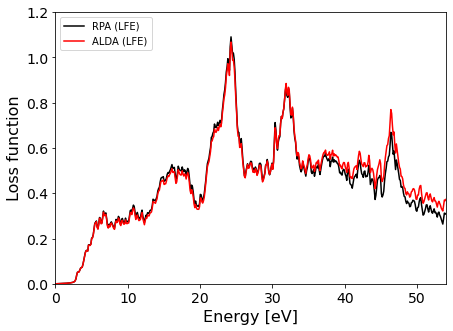

In [16]:
loss_fxcALDA = np.genfromtxt(join(cwd, 'LOSS_FXCALDA_OC11_QMT001.OUT'))
plt.figure(figsize = (7, 5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot(loss_fxcRPA[:, 0], loss_fxcRPA[:, 1], color = "black")
plt.plot(loss_fxcALDA[:, 0], loss_fxcALDA[:, 1], color = "red")
plt.xlabel('Energy [eV]', fontsize = 16)
plt.ylabel('Loss function', fontsize = 16)
plt.xlim(0, 54)
plt.ylim(0.0, 1.2)
RPA_LFE_label = Line2D( [0 ], [0 ], label = 'RPA (LFE)', color = 'black')
ALDA_LFE_label = Line2D( [0 ], [0 ], label = 'ALDA (LFE)', color = 'red')
plt.legend(handles = [RPA_LFE_label, ALDA_LFE_label], loc = 'upper left')
plt.show()

As one can see, in this case using a different **xc** kernel affects the loss spectra only in the high-energy region to a minor extent.

For more detailed information on the different kernels available in **TDDFT**, we refer the reader to [<span style="color:firebrick">Many-body kernels for TDDFT calculations</span>](http://exciting.wikidot.com/oxygen-many-body-kernels-for-tddft-calculations).

More details on the implementation of the **TDDFT** formalism within the **LAPW** method can be found in [<span style="color:firebrick">Refs.[3]</span>](#9) and [<span style="color:firebrick">[4]</span>](#10). A detailed study of the loss function of Silver using **exciting** can be found in [<span style="color:firebrick">Ref.[5]</span>](#11).

All of the main output files can be parsed by Python. In the example below, the results contained in main output file INFO.OUT are saved in the dictionary **converged_results**:

In [17]:
from excitingtools import parser_chooser

results = parser_chooser("./Ag-tddft/INFO.OUT")
max_scf = max([int(i) for i in results['scl'].keys()])
assert max_scf <= 14, "Expect max 14 SCF iterations to converge"
converged_results = results['scl'][str(max_scf)]

To test the correctness of obtained results, we can compare them with reference calculations. To do so within the notebook, execute the following cell :

In [18]:
from assertions_tddft import *

# Test results in main output file INFO.OUT.
test_groundstate(converged_results)

# Test results of loss function using RPA with local-field effects, for the XC kernel.
test_loss_fxc_RPA_LF(loss_fxcRPA)

# Test results of loss function using RPA without local-field effects, for the XC kernel.
test_loss_fxc_RPA_NLF(loss_fxcRPA_nlf)

# Test results of loss function using adiabatic LDA (ALDA) with local-field effects, for the XC kernel.
test_loss_fxc_ALDA_LF(loss_fxcALDA)

# Test results of loss function using adiabatic LDA (ALDA) without local-field effects, for the XC kernel.
loss_fxcALDA_nlf = np.genfromtxt(join(cwd, 'LOSS_NLF_FXCALDA_OC11_QMT001.OUT'))
test_loss_fxc_ALDA_NLF(loss_fxcALDA_nlf)

# Test results of dielectric function using RPA with local-field effects, for the XC kernel.
dielectric_fxcRPA = np.genfromtxt(join(cwd, 'EPSILON_FXCRPA_OC11_QMT001.OUT'))
test_dielectric_fxc_RPA_LF(dielectric_fxcRPA)

# Test results of dielectric function using RPA without local-field effects, for the XC kernel.
dielectric_fxcRPA_nlf = np.genfromtxt(join(cwd, 'EPSILON_NLF_FXCRPA_OC11_QMT001.OUT'))
test_dielectric_fxc_RPA_NLF(dielectric_fxcRPA_nlf)

# Test results of dielectric function using adiabatic LDA (ALDA) with local-field effects, for the XC kernel.
dielectric_fxcALDA = np.genfromtxt(join(cwd, 'EPSILON_FXCALDA_OC11_QMT001.OUT'))
test_dielectric_fxc_ALDA_LF(dielectric_fxcALDA)

# Test results of dielectric function using adiabatic LDA (ALDA) without local-field effects, for the XC kernel.
dielectric_fxcALDA_nlf = np.genfromtxt(join(cwd, 'EPSILON_NLF_FXCALDA_OC11_QMT001.OUT'))
test_dielectric_fxc_ALDA_NLF(dielectric_fxcALDA_nlf)

<hr style="border:1px solid #DDD"> </hr>

### <span style="color:black">Bibliography</span>

1. <a id='7'></a>The ground-state calculation can be also triggered from scratch from the <code><span style="color:green">xs</span></code> element with the <code><span style="color:mediumblue">dogroundstate</span></code> attribute of <code><span style="color:green">xs</span></code>, this is indeed needed in spin polarized calculations. For an example refer to [<span style="color:firebrick">Magneto-optical Kerr effect (MOKE)</span>](http://exciting.wikidot.com/oxygen-moke-effect).
2. <a id='8'></a>"Local Field Effects in the Electron Energy Loss Spectra of Rutile TiO2", Phys. Rev. Lett. **88**, 037601 (2002).
3. <a id='9'></a>S. Sagmeister, PhD thesis, University of Graz, August 2009 ([<span style="color:firebrick">PDF</span>](https://unipub.uni-graz.at/obvugrhs/download/pdf/208046?originalFilename=true)).
4. <a id='10'></a>Tutorial talk by Stefan Sagmeister ([<span style="color:firebrick">PDF</span>](http://exciting.wdfiles.com/local--files/boron-excited-states-from-tddft/cecam-tddft.pdf)) at the **<span style="color:firebrick">HoW exciting! 2010</span>** workshop in Lausanne.
5. <a id='11'></a>Further information on the momentum-dependent loss function of Ag: A. Alkauskas, S. Schneider, S. Sagmeister, C. Ambrosch-Draxl, and C. Hèbert, *Theoretical analysis of the momentum-dependent loss function of bulk Ag*, Ultramicroscopy **110**, 1081 (2010) ([<span style="color:firebrick">PDF</span>](https://www.sciencedirect.com/science/article/pii/S0304399109002745?via%3Dihub)).